# Tuning MCTS params to support policy training

We are using the Upper Confidence Bound for MCTS

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import numpy as np

from tqdm import tqdm

from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame as Game
from aegomoku.interfaces import MctsParams
from aegomoku.constants_15x15 import *
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from aegomoku.utils import analyse_board

import tensorflow as tf

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
BOARD_SIZE = 15

In [4]:
project = tf.keras.layers.Conv2D(
    name='project',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([512, 256, 128, 64, 32, 16, 8, 4, 2, 1]))

peel = tf.keras.layers.Conv2D(
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([
        [[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]
    ]),
    bias_initializer=tf.constant_initializer(0.),
    trainable=False)

def print_channel(data, channel=None):
    """
    :param data: policy output, either one or six channels
    :param channel: if data is 6-channel, number of channel from 1: strongest offensive opportunity to 6 weakest defensive
    :return:
    """
    if np.shape(data)[-1] == 10:
        if channel is not None:
            channel -= 1
            data = np.expand_dims(data[:,:,:,channel], -1)
        else:
            data = project(data)
    data = peel(data)
    print((data.numpy().reshape([15, 15]) ).astype(np.uint))

---
### The initial setup

In [12]:
from aegomoku.policies.heuristic_value_model import HeuristicValueModel

stones = [C11, F9, E9, G8, F7, G7, G9, H8, G6, H5]
from aegomoku.policies.heuristic_advice import HeuristicPolicyParams, HeuristicAdviser, HeuristicValueParams

policy_params = HeuristicPolicyParams(board_size=BOARD_SIZE)
value_params = HeuristicValueParams(board_size=BOARD_SIZE, value_gauge=0.5)
value_model = HeuristicValueModel(value_params)
adviser = HeuristicAdviser(policy_params, value_model)

the_game = Game(BOARD_SIZE, initializer=ConstantBoardInitializer(stones))
mcts_params = MctsParams(cpuct=4., num_simulations=1000, temperature=0.0, gamma=1.0)

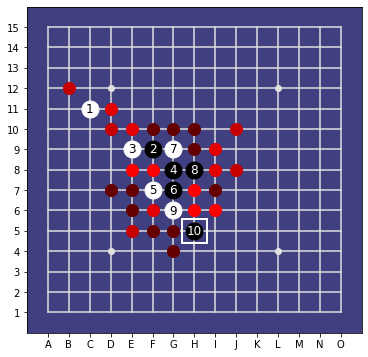

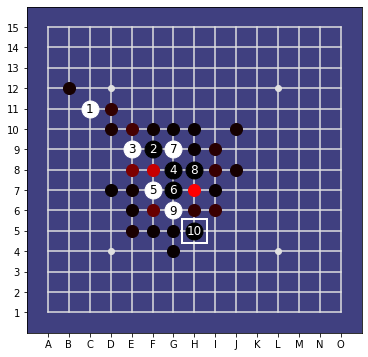

In [13]:
player = PolicyAdvisedGraphSearchPlayer(the_game, adviser, mcts_params)
board = GomokuBoard(BOARD_SIZE, stones=stones)
analyse_board(BOARD_SIZE, stones, adviser, disp_width=6)
mcts = player.mcts
mcts_advice = player.mcts.get_action_prob(board, temperature=.9)
analyse_board(BOARD_SIZE, stones, mcts_advice, disp_width=6, policy_cutoff=.001)

In [14]:
advisable = [board.Stone(i) for i in adviser.get_advisable_actions(board.math_rep)]
print(advisable)
print(value_model.evaluate(board.math_rep))
policy = {stone: adviser.advise(board.math_rep)[stone.i] for stone in advisable}
history = {stone: mcts.Usa[(board.get_string_representation(), stone.i)] for stone in advisable}

[B12, D11, D10, E10, F10, G10, H10, J10, H9, I9, E8, F8, I8, J8, D7, E7, H7, I7, E6, F6, H6, I6, E5, F5, G5, G4]
-0.27070802


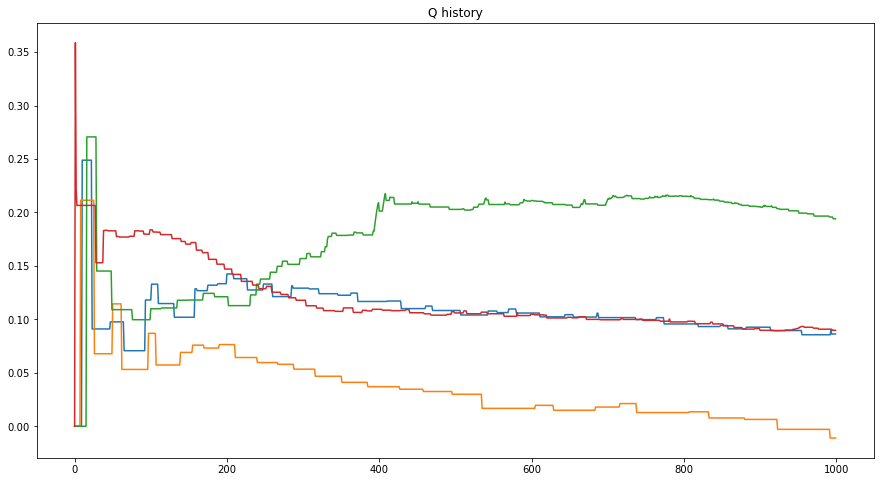

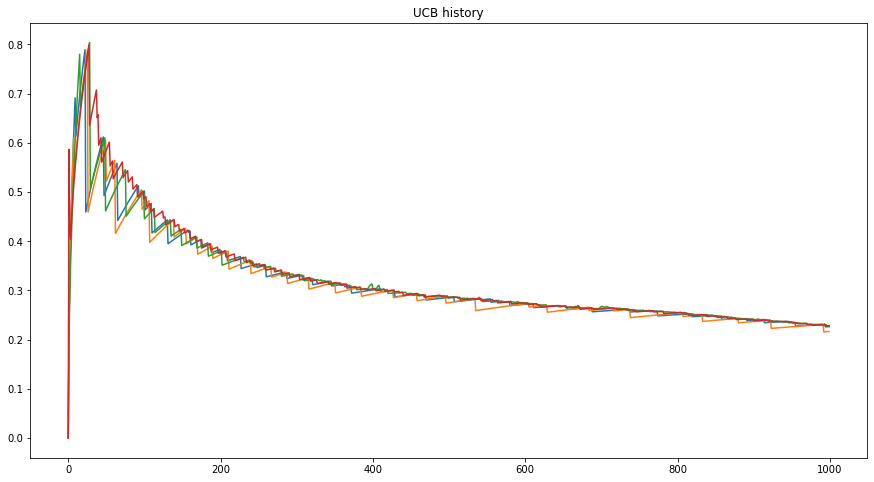

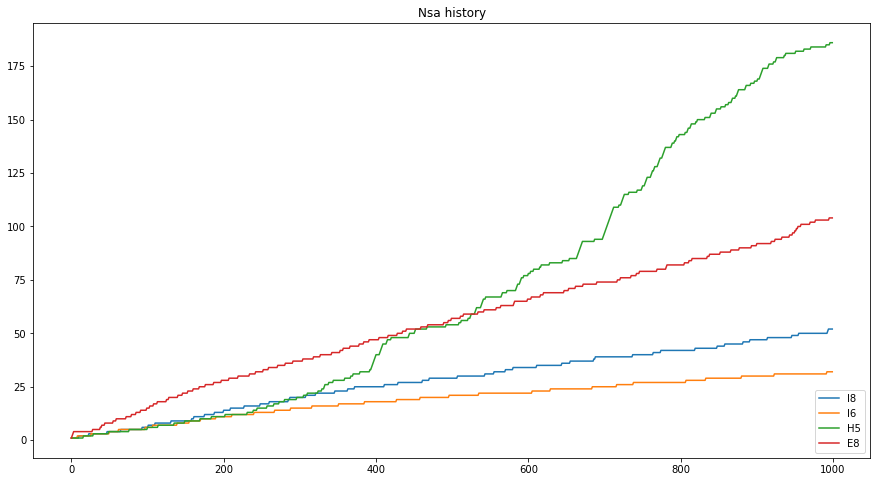

In [9]:
import matplotlib.pyplot as plt
def compare(history, *positions):

    x = range(len(history[positions[0]]))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_title("Q history")
    for position in positions:
        q = [u[1] for u in history[position]]
        ax.plot(x, q, label=str(position))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_title("UCB history")
    for position in positions:
        q = [u[0] for u in history[position]]
        ax.plot(x, q, label=str(position))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_title("Nsa history")
    for position in positions:
        q = [u[4] for u in history[position]]
        ax.plot(x, q, label=str(position))

    plt.legend(loc='lower right')

compare(history, I8, I6, H5, E8)

In [10]:
def look_ahead(board, stone):
    next = copy.deepcopy(board)
    next.act(stone).plot()
    s = next.get_string_representation()
    print(f"Visited {mcts.Ns[s]} times")
    print(f"Continuations: {[board.Stone(i) for i in mcts.As[s]]}")
    print(f"Value: {max([ mcts.Q[(s, i)] for i in mcts.As[s]])}")

In [11]:
look_ahead(board, H5)

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  X  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  X  O  X  .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  O  O  .  .  .  .  .  .  .    
 7    .  .  .  .  .  X  O  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  X  .  .  .  .  .  .  .  .    
 5    .  .  .  .  .  .  . [O] .  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O
Visited 184 times
Continuations:

In [136]:
def best_move(mcts, board):
    probs = mcts.compute_probs(board, 0)
    best_move = int(np.squeeze(np.where(np.array(probs) == 1)))
    best_move = board.Stone(best_move)
    return best_move

H6
P-Value: -0.0770648792386055


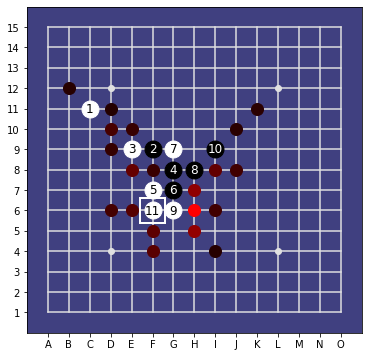

In [138]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
move = best_move(mcts, board)
print(move)
print(f"Value estimate: {adviser.evaluate(board.math_rep)[1]}")
mcts_advice = mcts.compute_probs(board, 1.0)
analyse_board(BOARD_SIZE, board.get_stones(), mcts_advice, disp_width=6, policy_cutoff=.001)

E2
P-Value: -0.05063730105757713


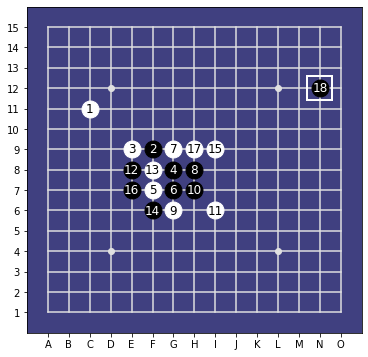

In [28]:
board.act(move.i)
move = best_move(mcts, board)
print(move)
print(f"P-Value: {adviser.evaluate(board.math_rep)[1]}")
mcts_advice = mcts.compute_probs(board, 3.0)
analyse_board(BOARD_SIZE, board.get_stones(), mcts_advice, disp_width=6, policy_cutoff=.001)

# Essential Parameter: MCTS score read-out temperature
A readout temperature between 4 and 6 will produce a reasonable input for future advice!

Policy with decreasing readout temperatur


100%|██████████| 6/6 [00:00<00:00, 28.25it/s]


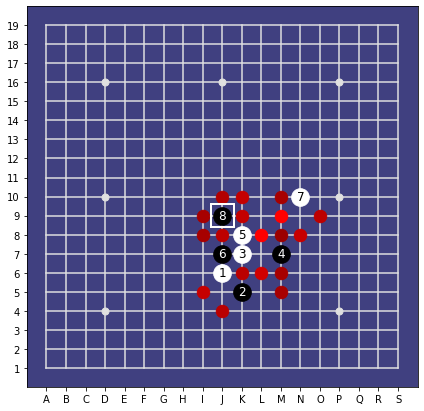

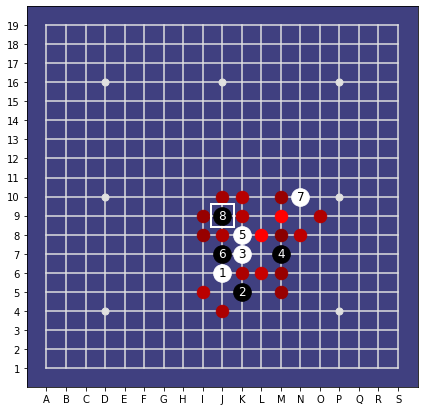

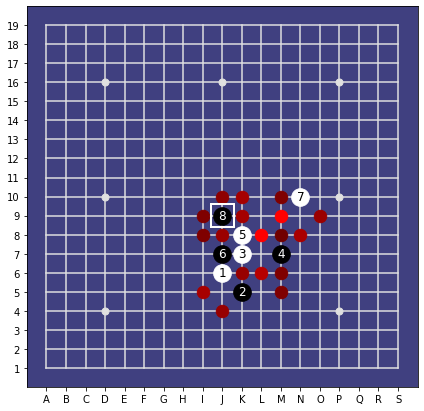

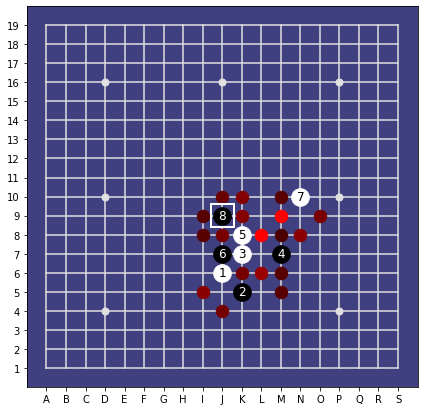

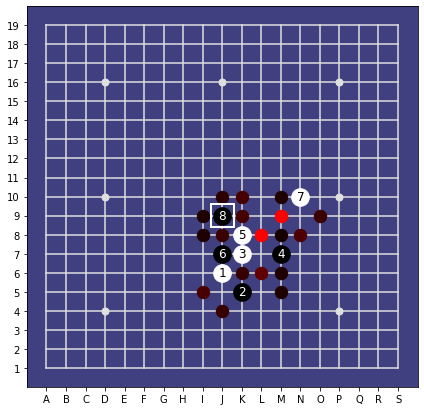

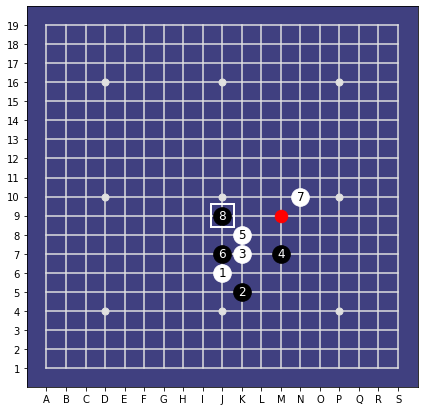

In [20]:
print("Policy with decreasing readout temperatur")
player.refresh()
player.mcts.get_action_prob(board)
for t in tqdm(range(10, -1, -2)):
    probs, v = player.evaluate(board, t)
    analyse_board(BOARD_SIZE, stones, probs, disp_width=7, policy_cutoff=.01)

In [26]:
probs, _ = player.evaluate(board, temperature=3)
print((np.reshape(probs, (BOARD_SIZE, BOARD_SIZE)) * 99 / np.max(probs)).astype(int))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16 25  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0 25  0 99  0 21  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11 21  0 98  8 28  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 19 35 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 26  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

In [14]:
(10**10 + 10**10)**.1

10.717734625362933